# Projeto de categorização de criticas

O objetivo é mostrar tecnicas e modelos diversos usados para classificação de texto, para isso treinarei um modelo para detectar automaticamente resenhas negativas. 

Usarei um conjunto de dados de resenhas de filmes do IMDB com rotulagem de polaridade para criar um modelo para classificar resenhas como positivas e negativas. 

## Inicialização

In [40]:
import math

import numpy as np
import pandas as pd
import re

from nltk.corpus import stopwords as nltk_stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from enelvo.normaliser import Normaliser

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

/opt/homebrew/lib/python3.11/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.7.1) was trained with spaCy v3.7.2 and may not be 100% compatible with the current version (3.8.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [41]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# a próxima linha fornece gráficos de melhor qualidade em telas HiDPI
%config InlineBackend.figure_format = 'retina'
print(plt.style.available)
plt.style.use('seaborn-v0_8')

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [42]:
# isso é para usar progress_apply, leia mais em https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Carregar Dados

In [43]:
df_reviews = pd.read_csv('/Users/mhctds/Film_review_avaliation_Matheus/data/raw/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
print(df_reviews.head(5))
df_reviews.describe()

      tconst title_type primary_title original_title  start_year end_year  \
0  tt0068152      movie             $              $        1971       \N   
1  tt0068152      movie             $              $        1971       \N   
2  tt0313150      short          '15'           '15'        2002       \N   
3  tt0313150      short          '15'           '15'        2002       \N   
4  tt0313150      short          '15'           '15'        2002       \N   

  runtime_minutes  is_adult              genres  average_rating  votes  \
0             121         0  Comedy,Crime,Drama             6.3   2218   
1             121         0  Comedy,Crime,Drama             6.3   2218   
2              25         0  Comedy,Drama,Short             6.3    184   
3              25         0  Comedy,Drama,Short             6.3    184   
4              25         0  Comedy,Drama,Short             6.3    184   

                                              review  rating   sp  pos  \
0  The pakage impl

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,47329.0,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,25562.917323,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,83670.039163,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.0,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,827.0,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3197.0,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,13974.0,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1739448.0,10.000000,1.000000,12499.000000


In [44]:
df_reviews=df_reviews.drop_duplicates(subset=set(df_reviews).remove('tconst'))
df_reviews=df_reviews.dropna()
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47329 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47329 non-null  object 
 1   title_type       47329 non-null  object 
 2   primary_title    47329 non-null  object 
 3   original_title   47329 non-null  object 
 4   start_year       47329 non-null  int64  
 5   end_year         47329 non-null  object 
 6   runtime_minutes  47329 non-null  object 
 7   is_adult         47329 non-null  int64  
 8   genres           47329 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47329 non-null  object 
 12  rating           47329 non-null  int64  
 13  sp               47329 non-null  object 
 14  pos              47329 non-null  int64  
 15  ds_part          47329 non-null  object 
 16  idx              47329 non-null  int64  
dtypes: Int64(1), floa

### Armazenando os dados processados

In [45]:
df_reviews.to_csv('/Users/mhctds/Film_review_avaliation_Matheus/data/processed/imdb_reviews.tsv', sep='\t')

## AED (Analise e Exploração de Dados)

Fase importante para determinar quais são as melhores tecnicas a serem usadas nos dados ou medidas no modelo, com enfase em descobrir como esta a distribuição das classes por quantidade, tempo, etc...

Mostrando o numero de resenhas por ano. 

Azul são as negativas e verde as positivas no segundo grafico.

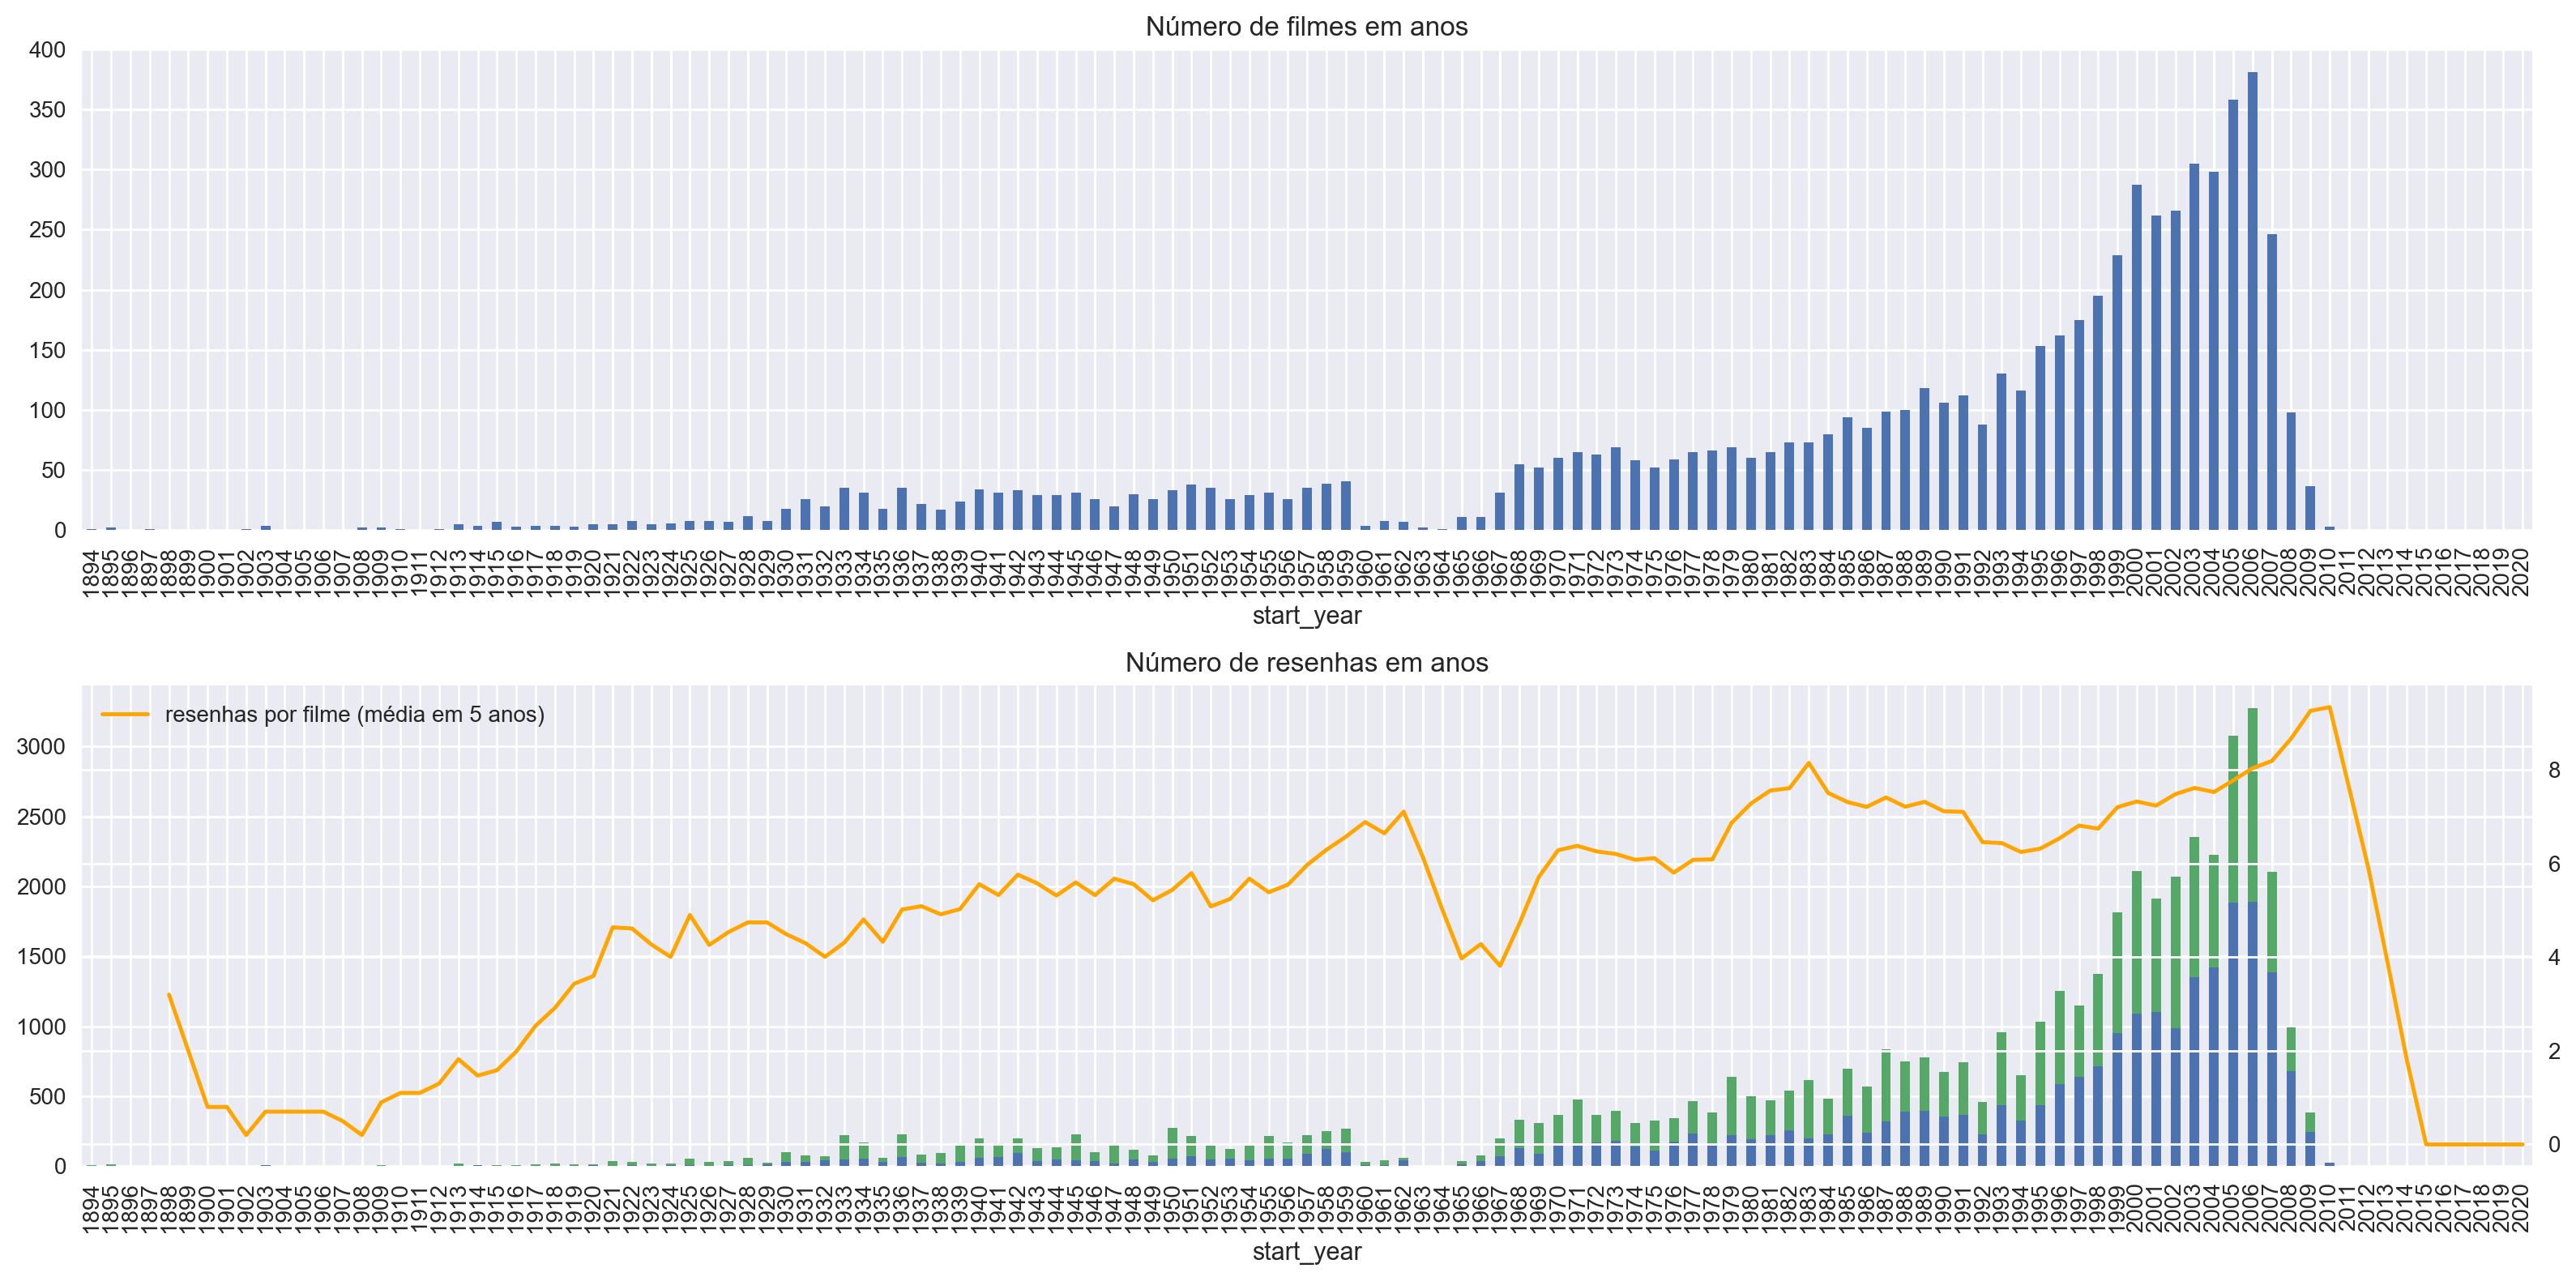

In [46]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de filmes em anos')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='resenhas por filme (média em 5 anos)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de resenhas em anos')

fig.tight_layout()

Vamos verificar a distribuição do número de resenhas por filme com a contagem exata e o EDK (Estimativa de densidade kernel)

EDK calcula a densidade de resenhas por filme para aquele pedaço do grafico, ajudando a interpretar dados que não seguem uma distribuição normal, binomial, etc. Basicamente dexa os grafico bonitinho, arrendondado e facil de tirar conclusões.

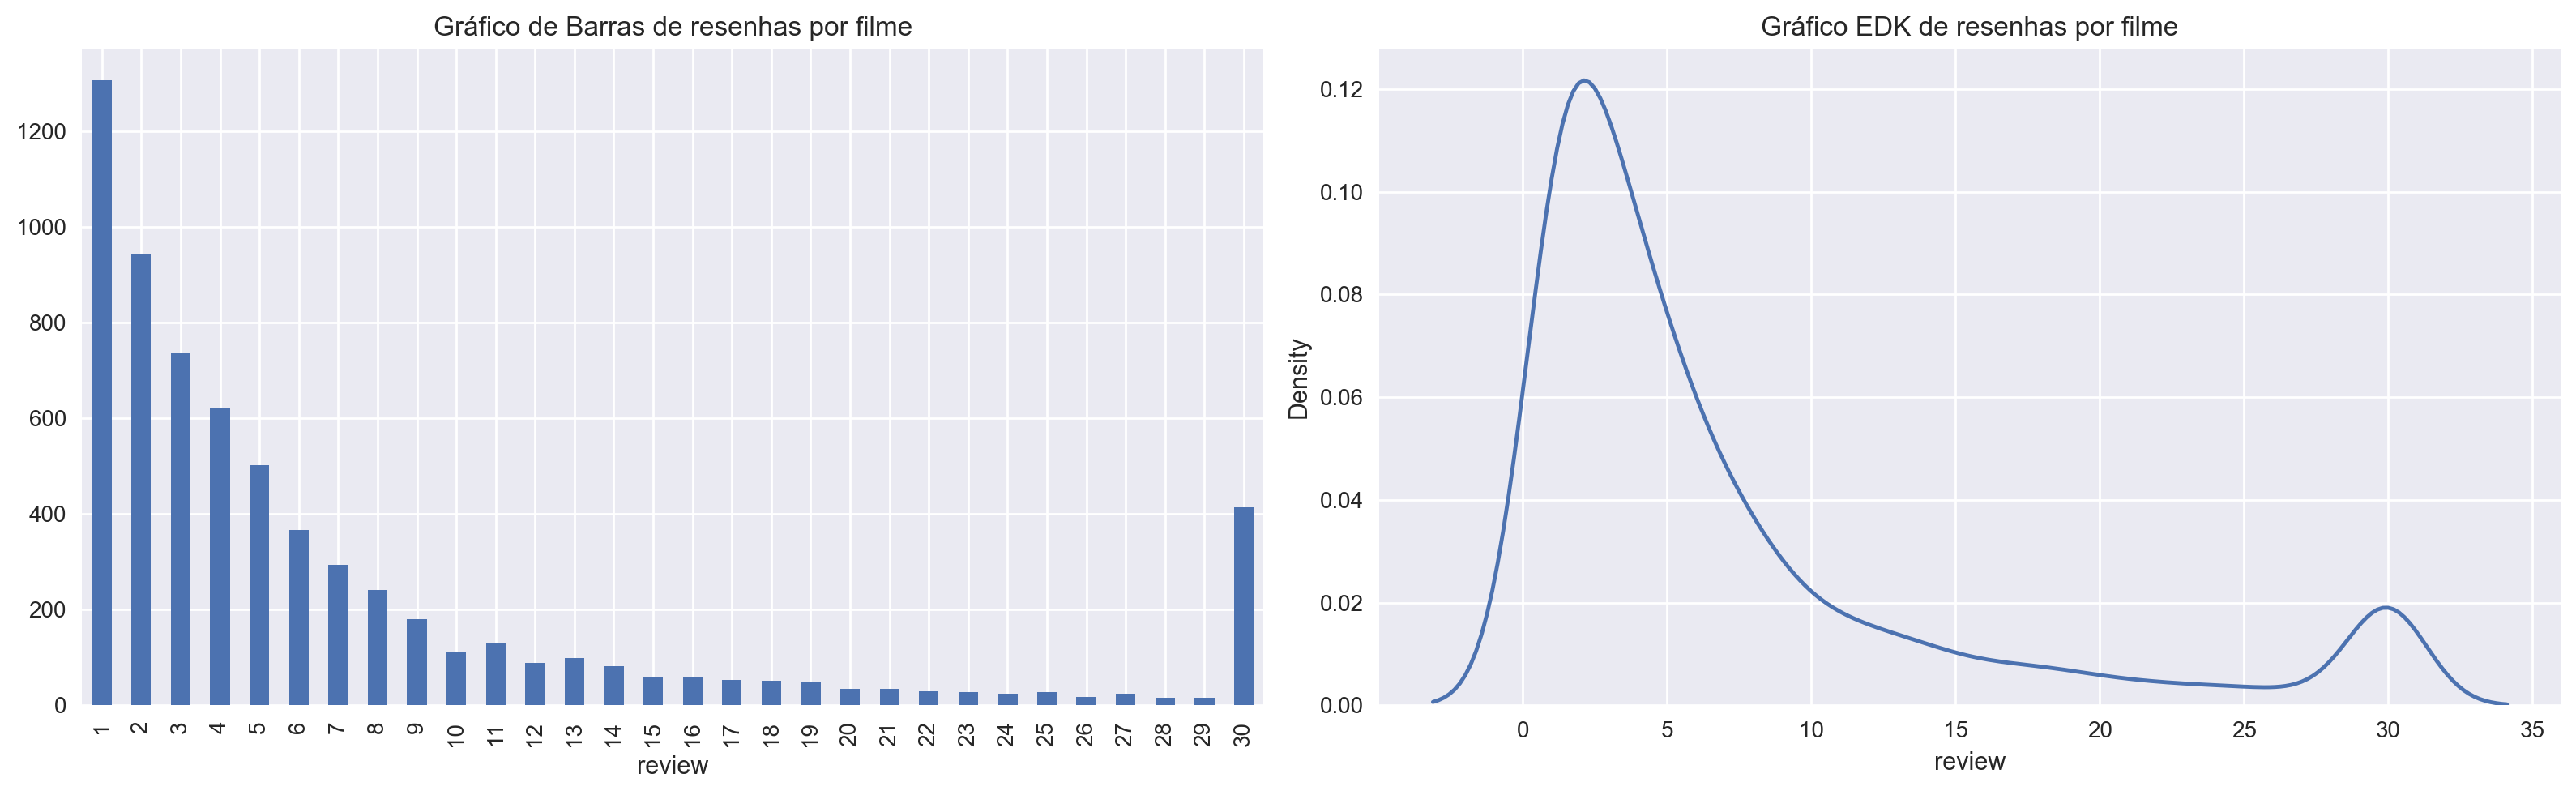

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de Barras de resenhas por filme')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico EDK de resenhas por filme')

fig.tight_layout()

Alguns filmes tem muito mais resenhas que outros, provavelmente por serem mais populares, mas alem de desequilibrar a classe, isso pode levar a uma limitação do vocabulario do modelo

In [48]:
df_reviews['pos'].value_counts()

pos
0    23715
1    23614
Name: count, dtype: int64

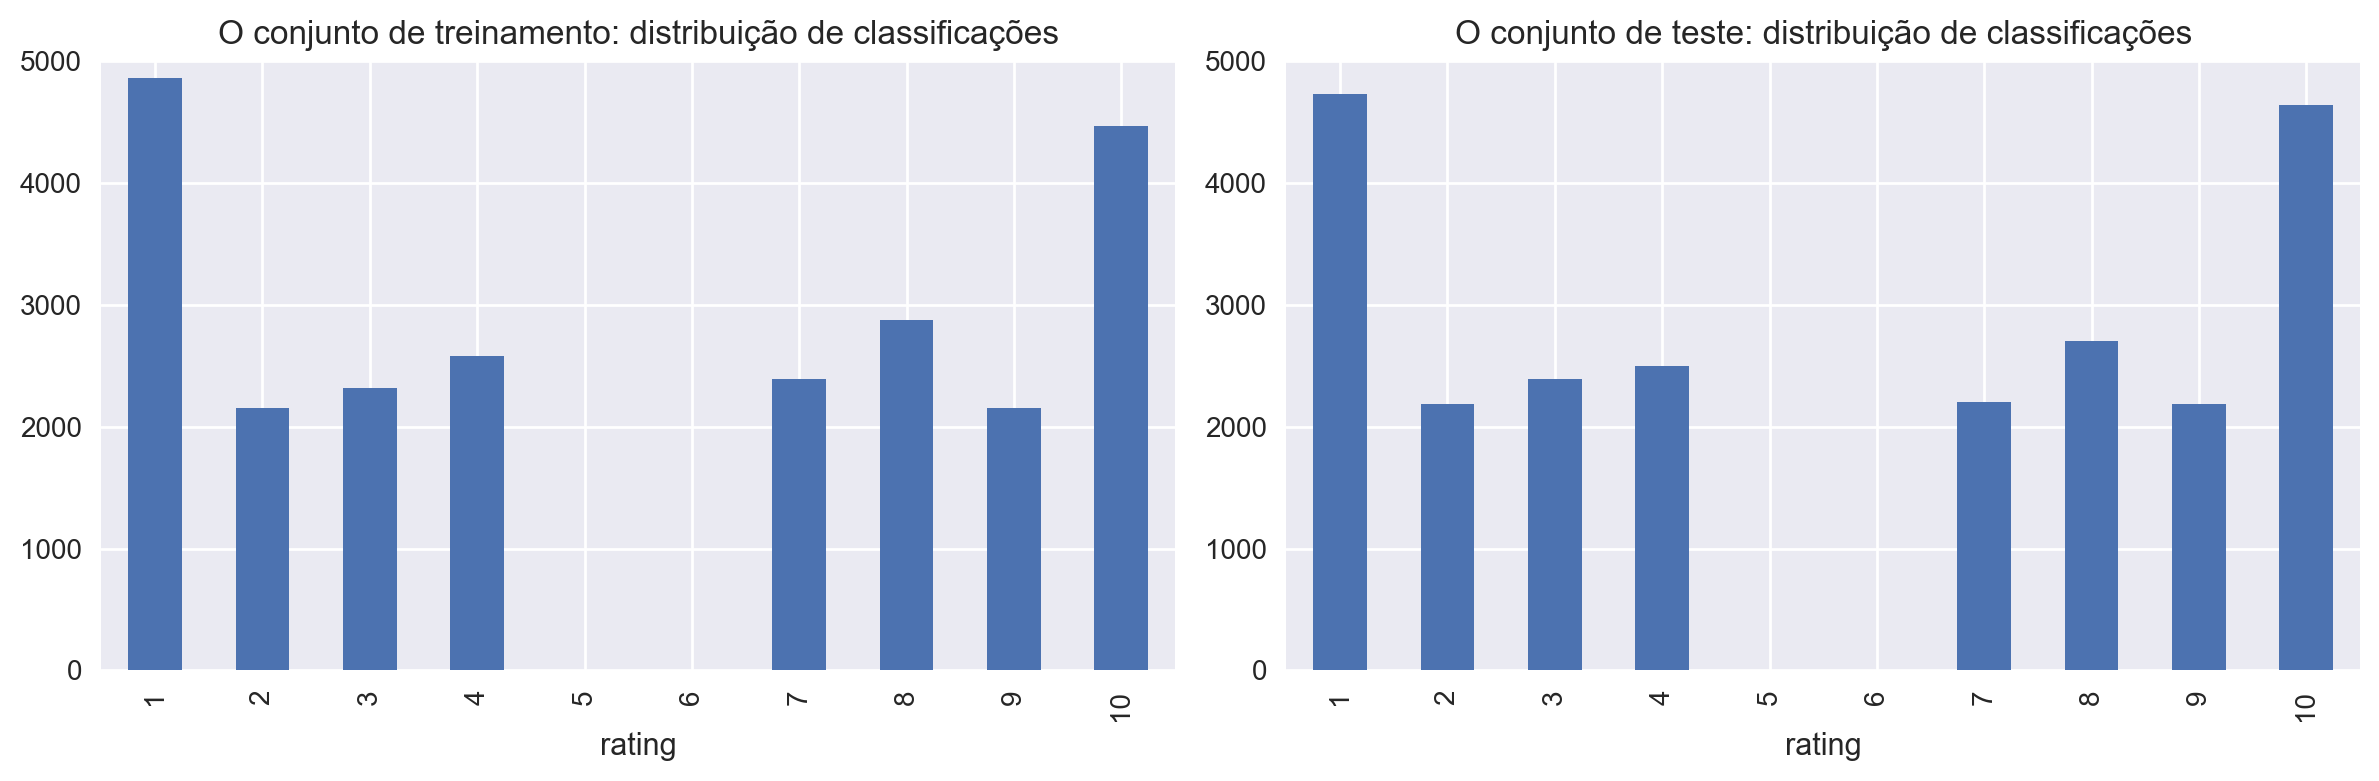

In [49]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('O conjunto de treinamento: distribuição de classificações')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('O conjunto de teste: distribuição de classificações')

fig.tight_layout()

Distribuição de resenhas negativas e positivas ao longo dos anos para duas partes do conjunto de dados

/var/folders/6m/8zrf46xx10z087pclwk1njth0000gn/T/ipykernel_53947/364716119.py:14: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
/var/folders/6m/8zrf46xx10z087pclwk1njth0000gn/T/ipykernel_53947/364716119.py:15: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
/var/folders/6m/8zrf46xx10z087pclwk1njth0000gn/T/ipykernel_53947/364716119.py:30: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
/var/folders/6m/8zrf46xx10z087pclwk1njth0000gn/T/ipyke

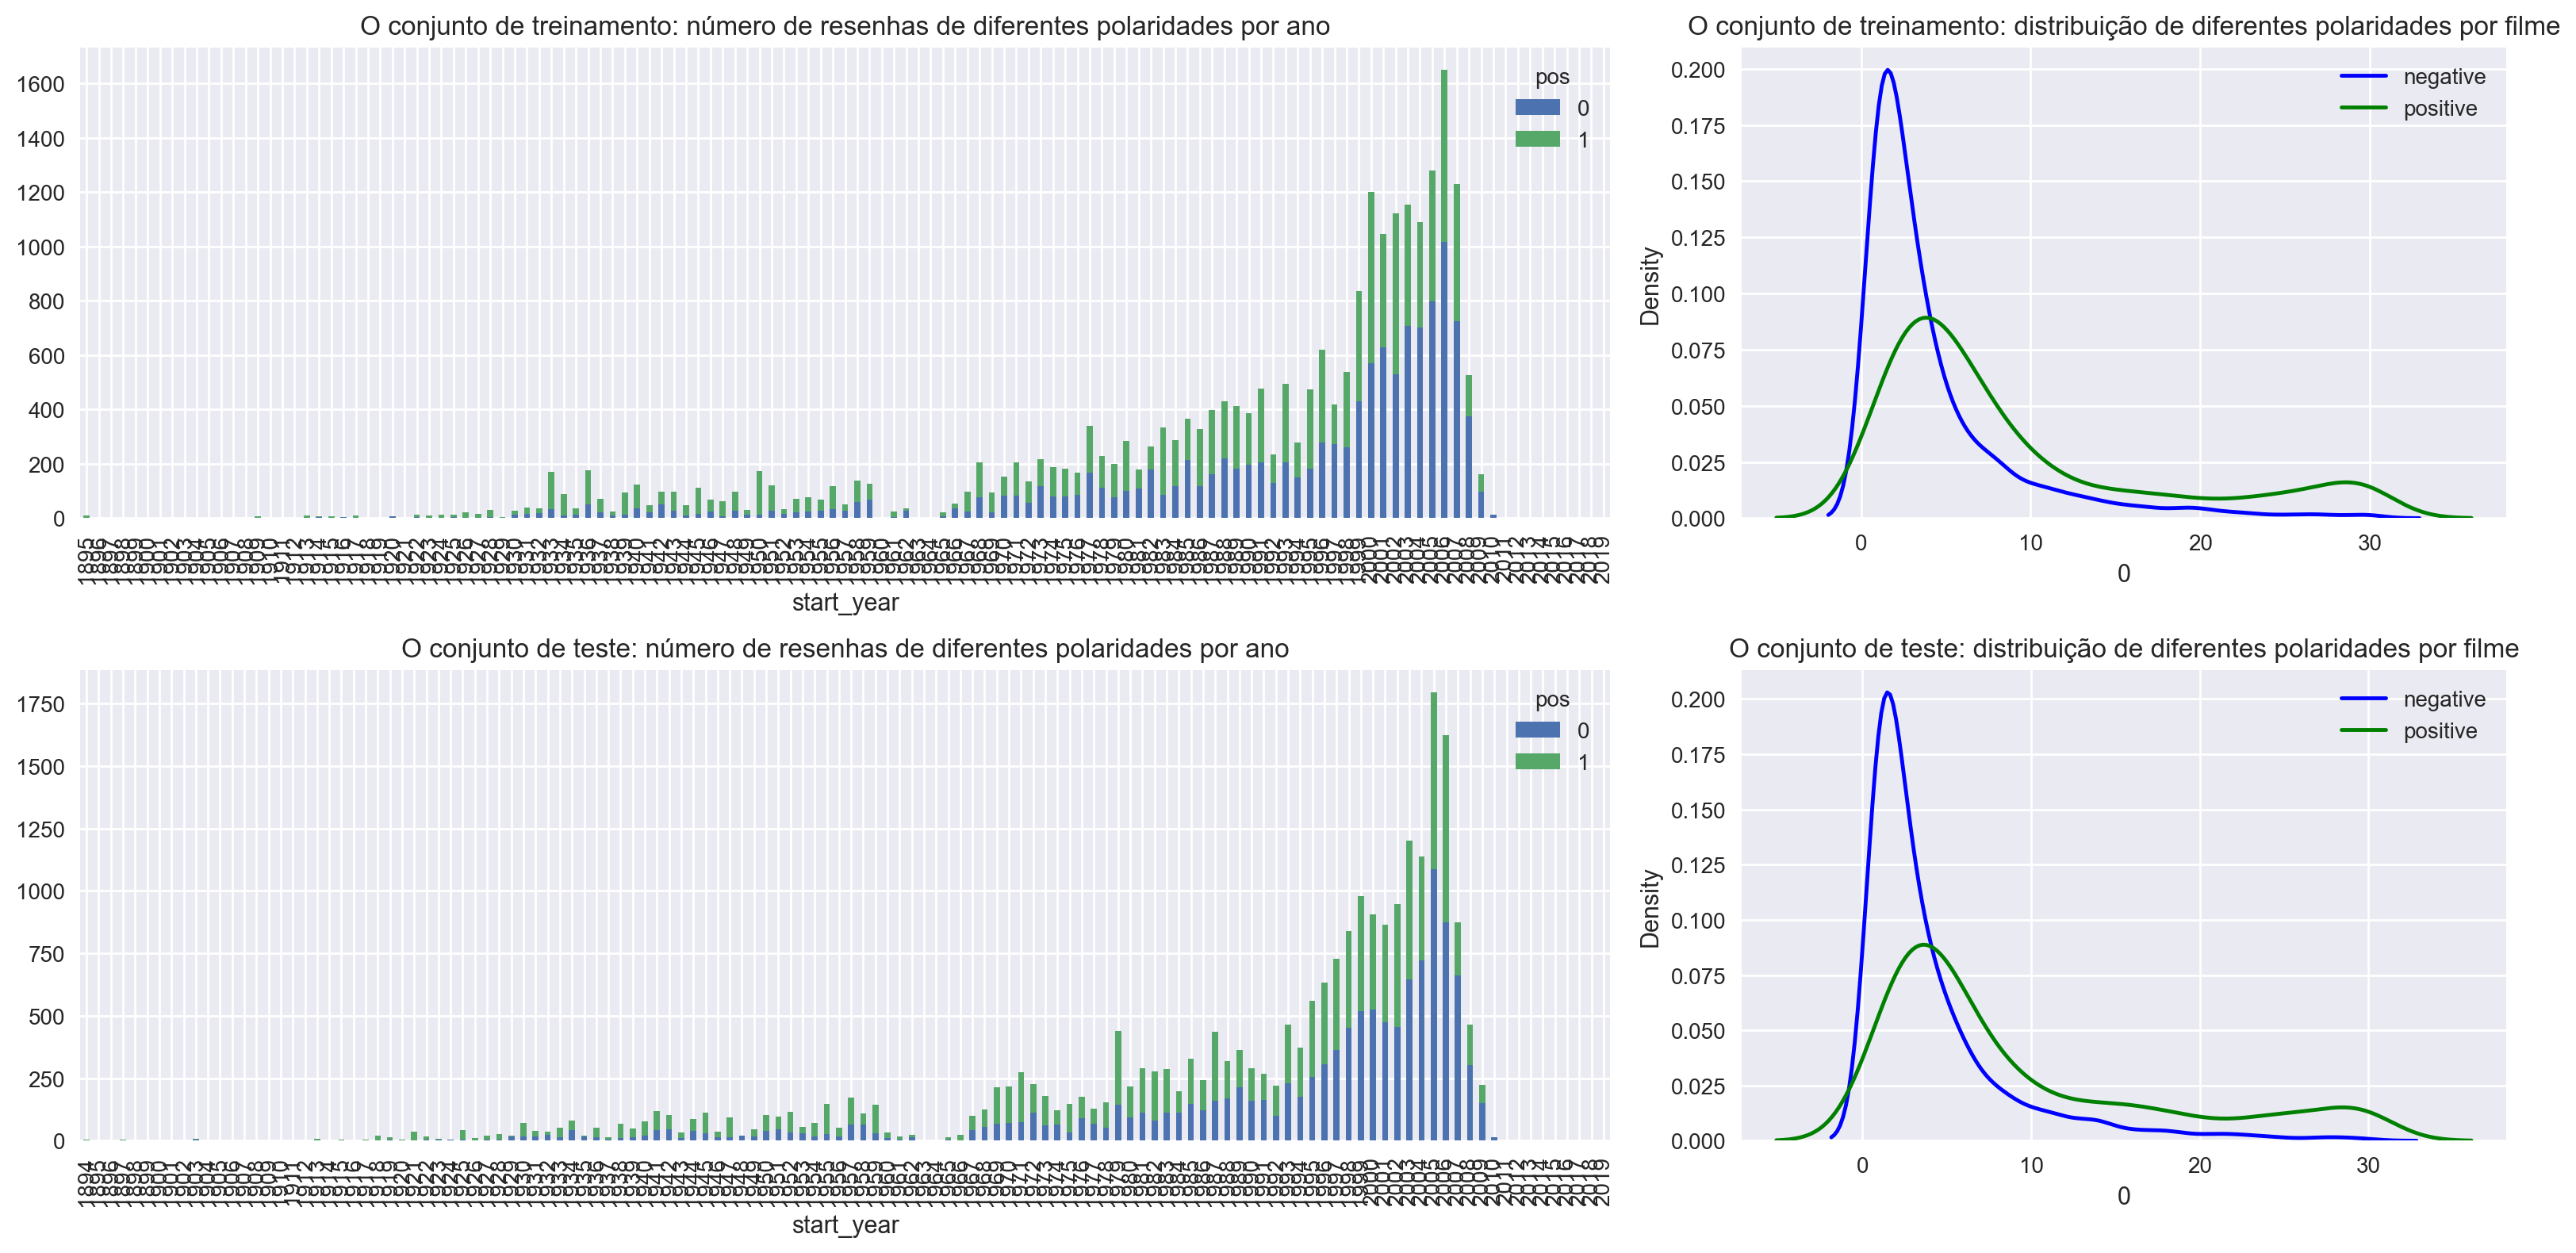

In [50]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('O conjunto de treinamento: número de resenhas de diferentes polaridades por ano')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('O conjunto de treinamento: distribuição de diferentes polaridades por filme')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('O conjunto de teste: número de resenhas de diferentes polaridades por ano')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('O conjunto de teste: distribuição de diferentes polaridades por filme')

fig.tight_layout()

As classes estão um pouco desequilibradas, com a quantidade de 1 ou positivos sendo o dobro de negativos ou 0.

Isso pode parecer um desequilibrio grande, mas em dados reais esse desequilibrio entre classes tende a ser muito maior.

Boas tecnicas para serem usadas nessa situação seriam upsampling nos negativos, multiplica-los em quantidade por 2, dar peso maior a classificação de negativos no modelo ou usar modelos que automaticamente priorizam previsões erradas, modelos com boost.

## Procedimento de Avaliação

Rotina de avaliação que pode ser utilizada para todos os modelos deste projeto

In [51]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # Curva de precisão-revocação
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # definindo cruzamentos para alguns limiares
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # Curva de precisão-revocação
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # definindo cruzamentos para alguns limiares
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        print("Acurácia",type," :",metrics.accuracy_score(target, pred_target))
        print("f1 ",type," :",metrics.f1_score(target, pred_target))
        
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Acurácia', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    
    return

Accuracy nos da a porcentagem de acertos em relação ao total de tentativas, não é uma metrica muito boa pois não avalia avaliações falsas e verdadeiras, só se errou ou não.

Precision é a porcentagem de acertos positivos verdadeiros pelo total de tudo classificado como positivo, falso ou verdadeiro, não é muito util quando temos muito mais classificações negativas que positivas, da enfase em falsos positivos.

Recall é a porcentagem de acertos positivos verdadeiros pelo total de positivos verdadeiros mais os falsos negativos, é bom para classificar eventos que ja ocorreram, como fraude e atos de violencia, pois da enfase em falsos negativos.

F1 é calculado usando falsos e verdadeiros positivos e negativos, pode ser considerada uma matrica que equilibra precision e recall.É uma boa metrica principal para a maioria dos modelos.

ROC é um grafico de curva baseado na probabilidade de um modelo acertar a classifação dado um certo nivel de treinamento.Desde que o dataset seja razoavelmente balanceado, quanto maior a area abaixo da curva(AUC), melhor o modelo.

PRC, ou curva de precisão recall é usada de maneira semelhante ao ROC, porem para dados desbalanceados.

## Normalização

Todos os modelos abaixo aceitam textos em letras minúsculas e sem dígitos, sinais de pontuação, etc.

Então colocamos todo o texto em minusculo e separamos palavra por palavra(tokens), aplicando nessas palavras o lematizador, que vai padronizar a conjugação, alem de tirar emojis, sinais de pontuação e qualquer coisa que possa interferir no treinamento.

Precisamos que as palavras estejam padronizadas, pois na hora que convertermos o texto em um vetor, se uma mesma palavra começar com minuscula ou maiuscula essas duas versões serão reconhecidas como palavras diferentes.

In [52]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

lemmatizer  = WordNetLemmatizer()

def lematizer(text):
    tokens = word_tokenize(text.lower())

    lemmas = [lemmatizer.lemmatize(token) for token in tokens] 
    
    return " ".join(lemmas)
texts=df_reviews['review']
lematized=[]
for text in tqdm(texts):
    lematized.append(lematizer(text))
df_reviews['review_norm'] = lematized
print(df_reviews['review'].head(1),df_reviews['review_norm'].head(1))

  0%|          | 0/47329 [00:00<?, ?it/s]

0    The pakage implies that Warren Beatty and Gold...
Name: review, dtype: object 0    the pakage implies that warren beatty and gold...
Name: review_norm, dtype: object


Abaixo esta uma versão desse lematizador em portugues, o enelvo.

In [53]:
Texto="Coloque o texto aqui"
normalizador = Normaliser(tokenizer='readable',sanitize=True)
print(normalizador.normalise(Texto).lower())

coloque o texto aqui


## Treinar / Testar Conjunto

Felizmente, todo o conjunto de dados já está dividido em partes de treinamento/teste. A opção correspondente é 'ds_part'.

In [54]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


Caso não estivesse usariamos o train_test_split abaixo, do scikit

In [55]:
#from sklearn.model_selection import train_test_split
#train_data, test_data, train_target, test_target = train_test_split(features, target, test_size=0.3, random_state=12345,shuffle=True)

## Trabalhando com modelos

### Modelo 0 - Constante

Modelo para simular como seria adivinhar as classes escolhendo a que acontece com mais frequencia sempre, serve como benchmark para a perfomance de modelos reais.

In [56]:
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

In [57]:

stop_words=list(nltk_stopwords.words('english'))
model=DummyClassifier(strategy="most_frequent")

In [58]:
corpus_train=df_reviews_train['review_norm']
corpus_test=df_reviews_test['review_norm']

vect=TfidfVectorizer(stop_words=stop_words)
train_features_1= vect.fit_transform(corpus_train)
test_features_1=vect.transform(corpus_test)

model.fit(train_features_1,train_target)
print(metrics.accuracy_score(test_target, model.predict(test_features_1)))

0.5015510134704457


Acurácia train  : 0.5005883341738108
f1  train  : 0.0
Acurácia test  : 0.5015510134704457
f1  test  : 0.0
          train  test
Acurácia    NaN   NaN
F1          NaN   NaN
APS         0.5   0.5
ROC AUC     0.5   0.5


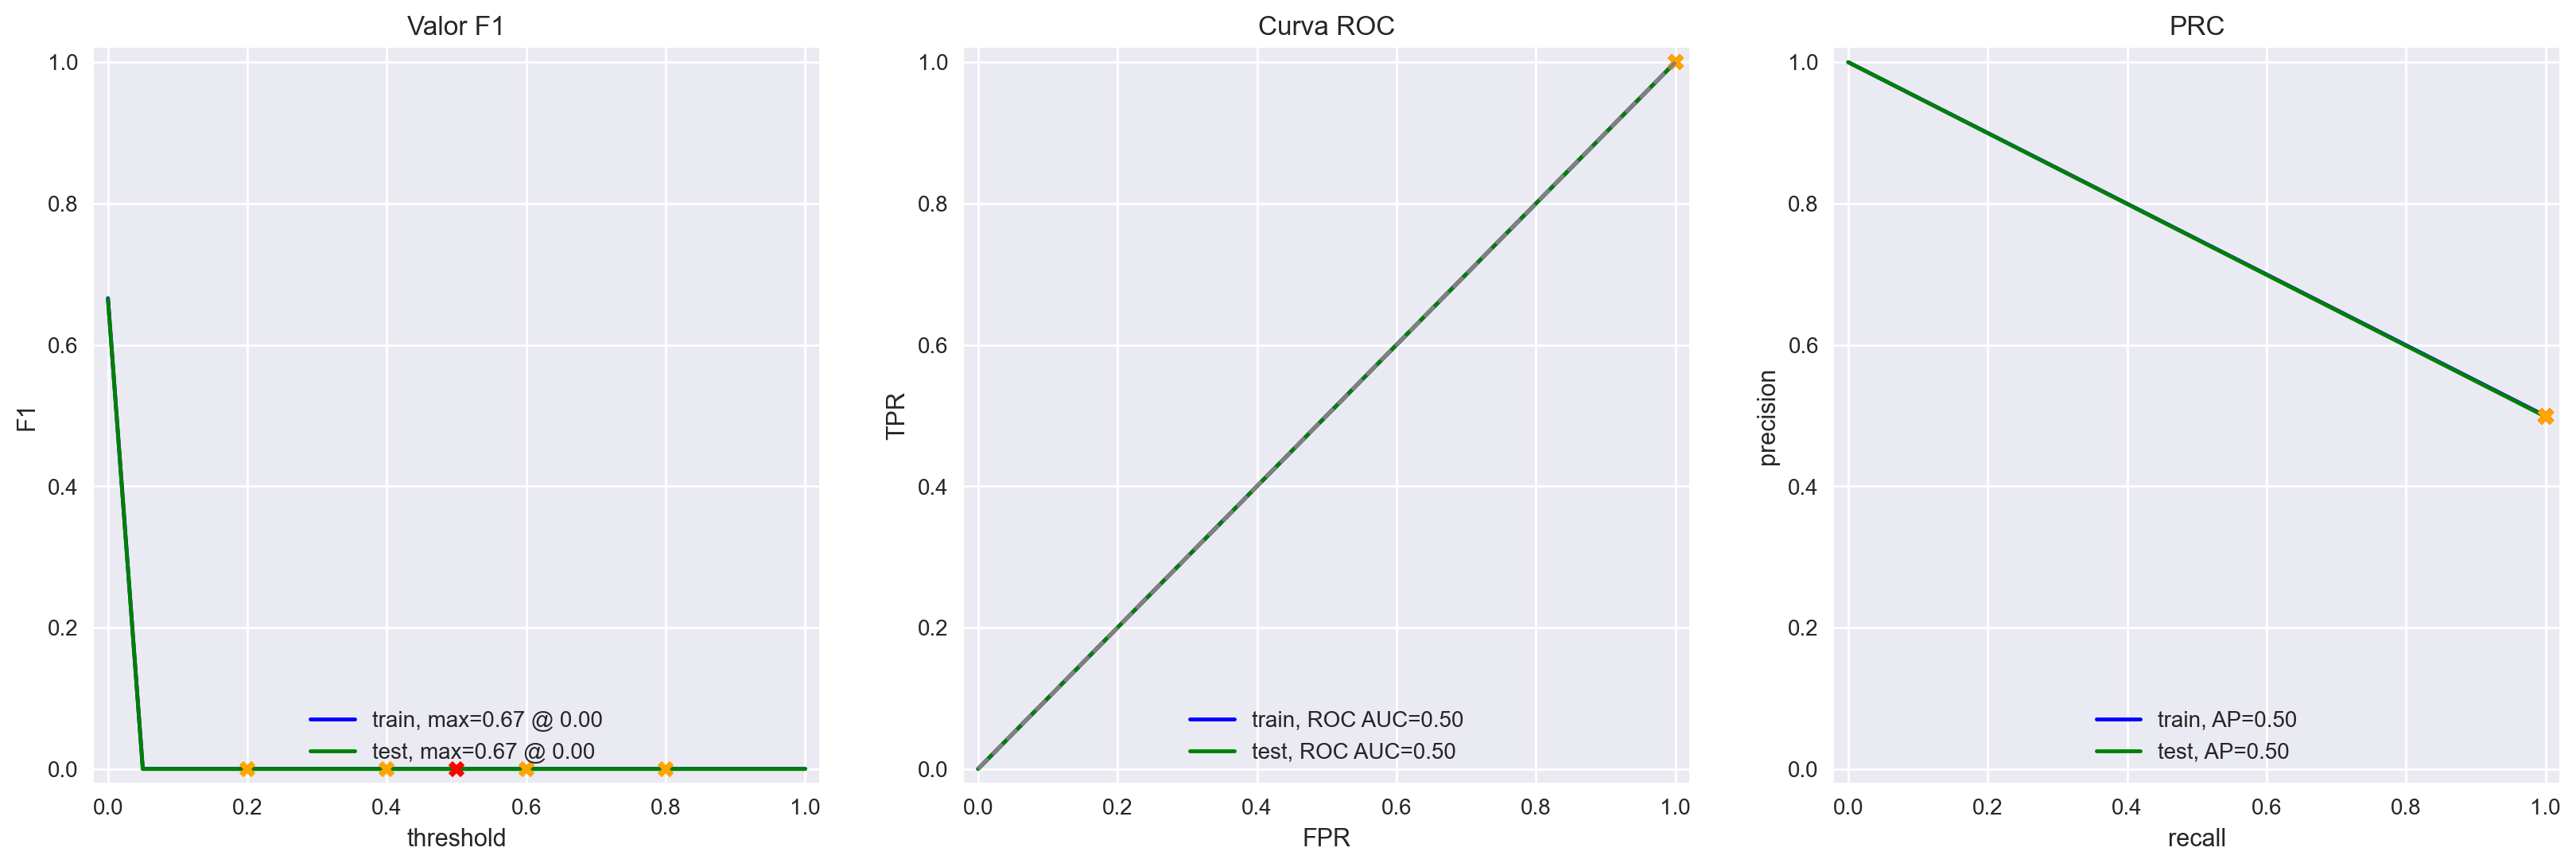

In [59]:
evaluate_model(model, train_features_1, train_target, test_features_1, test_target)

### Modelo 1 - NLTK, TF-IDF e Regressão Logistica

TF-IDF é um metodo de vetorização de palavras, onde cada palavra ganha importancia baseado em seu contexto e quantas vezes aparece no texto.

Ele é calculado em duas partes:

O TF é o numero de occorencias de uma palavra em texto especifico, divido pelo numero total de palavras no texto. Ele é calculado por texto ou frase, cada linha do csv.

O IDF é multiplicado ao TF,seu papel é diminuir a importancia de palavras comuns, que aparecem muitas vezes nos dados. Ele é baseado em um calculo usando todo os textos contidos nos dados, sendo o log de base 10 do numero de textos que a palavra apareceu dividido pelo total de textos. Caso voce separe os dados em teste e treinamento voce so treina a parte do idf com os dados de treinamento, para os dados sempre ficarem no mesmo formato final, algo necessario para o uso de modelos de IA, alem de ser mais justo pois o metodo de teste dos modelos tem que ser consistente. 

Com a exceção de modelos com sua propria vetorização, como o BERT, usamos o TF-IDF. Podemos considerar cada palavra unica como uma caracteristica que o modelo avalia.

Estarei usando como primeiro exemplo a regressão logistica, que ja vimos como funciona na aula, para mostrar um dos modelos que aprendemos em ação e compara-lo a outros modelos.

In [60]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [61]:
corpus_train=df_reviews_train['review_norm']
corpus_test=df_reviews_test['review_norm']

vect=TfidfVectorizer(stop_words=stop_words)
train_features_1= vect.fit_transform(corpus_train)
test_features_1=vect.transform(corpus_test)
original_vect=vect

model_1=LogisticRegression()
model_1.fit(train_features_1,train_target)
print(metrics.accuracy_score(test_target, model_1.predict(test_features_1)))

0.8799558067394723


Acurácia train  : 0.9357455034459573
f1  train  : 0.9360866112109685
Acurácia test  : 0.8799558067394723
f1  test  : 0.8794126435309685
          train  test
Acurácia    NaN   NaN
F1          NaN   NaN
APS        0.98  0.95
ROC AUC    0.98  0.95


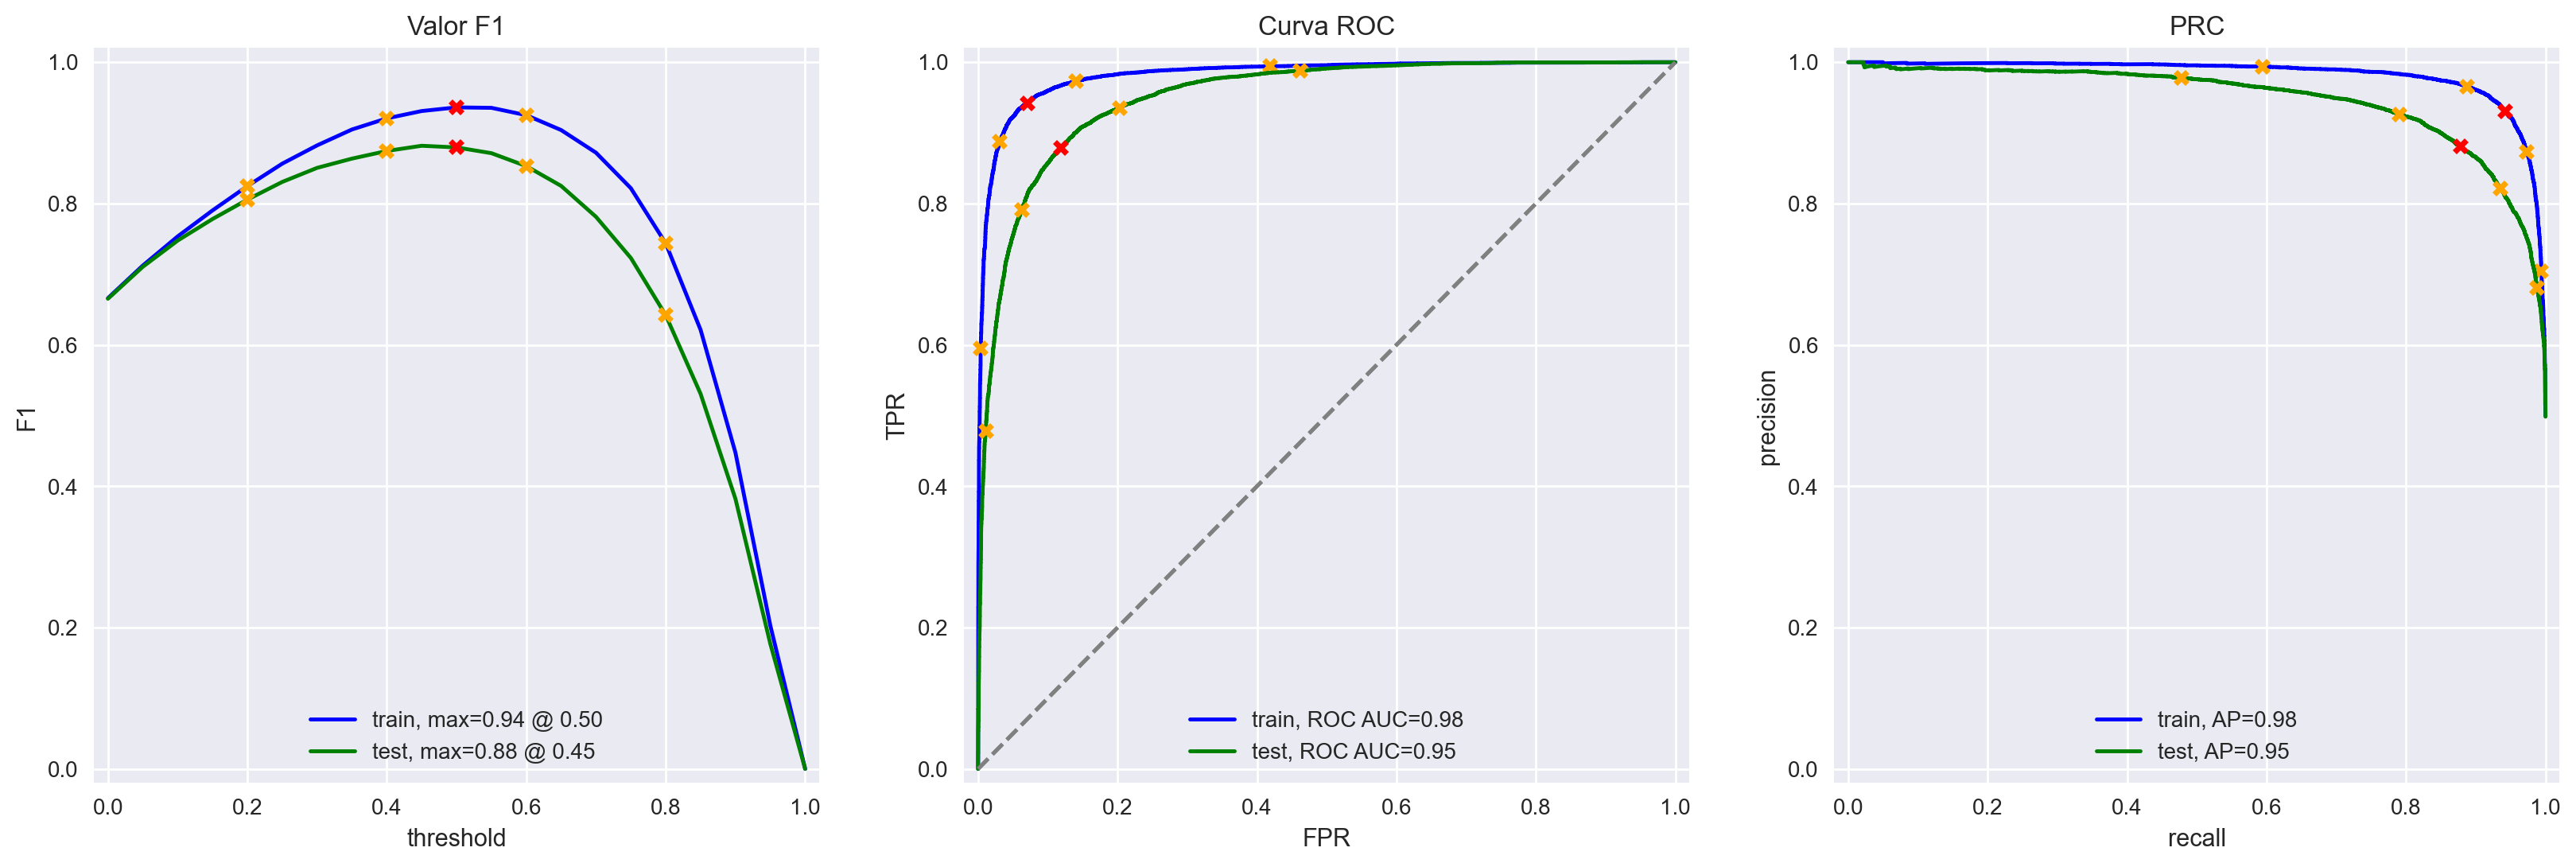

In [62]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Modelo 2 - NLTK, TF-IDF e Arvore de classificação

A arvore de classificação é um otimo modelo para quando as classes estão desbalanceadas, temos muito mais reviews positivos que negativas ou vice versa, alem de ter alta explicabilidade, diferente de modelos usando redes neurais, que muitas vezes funcionam como caixas pretas.

Elas funcionam em camadas, e o numero de camadas é a depth(Profundida), e o maximo de camadas possiveis pode ser limitado no inicio para evitar overfit. 

Cada camada e composta de modulos de decisão, que são um if para uma certa caracteristica, então temos um if na primeira camada, até dois na segunda, até quatro na terceira, etc, com um numero maximo de if igual 2ˆmax_depth-1.

Esses ifs são feitos determinando qual caracteristica é mais importante para classificação e qual é o melhor ponto para dividir os dados baseado nessa caracteristica, cada camada subsequente pegando caracteristicas cada vez mais importantes.

Com camadas o suficiente voce pode avaliar todas as caracteristicas dos dados e alcançar um precisão de 100% nos dados de treino, mas isso provavelmente causaria um overfit, e os dados de teste teriam uma pessima precisão.

As nossas classes não estão muito desbalançeadas, então a arvore não deve ter uma precisão muito maior que a regressão logisticas

In [63]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

In [64]:
best_f1=0
best_depth=0
for depth in tqdm(range(1,50)):
    model_2=DecisionTreeClassifier(max_depth=depth)
    model_2.fit(train_features_1,train_target)
    prediction=model_2.predict(test_features_1)
    if f1_score(test_target,prediction)>best_f1:
        best_model_2=model_2
        best_depth=depth
print(best_depth)

  0%|          | 0/49 [00:00<?, ?it/s]

49


Acurácia train  : 0.9670112623970415
f1  train  : 0.9678450006144267
Acurácia test  : 0.7166957039051545
f1  test  : 0.722150448010002
          train  test
Acurácia    NaN   NaN
F1          NaN   NaN
APS        0.99  0.63
ROC AUC    0.99  0.70


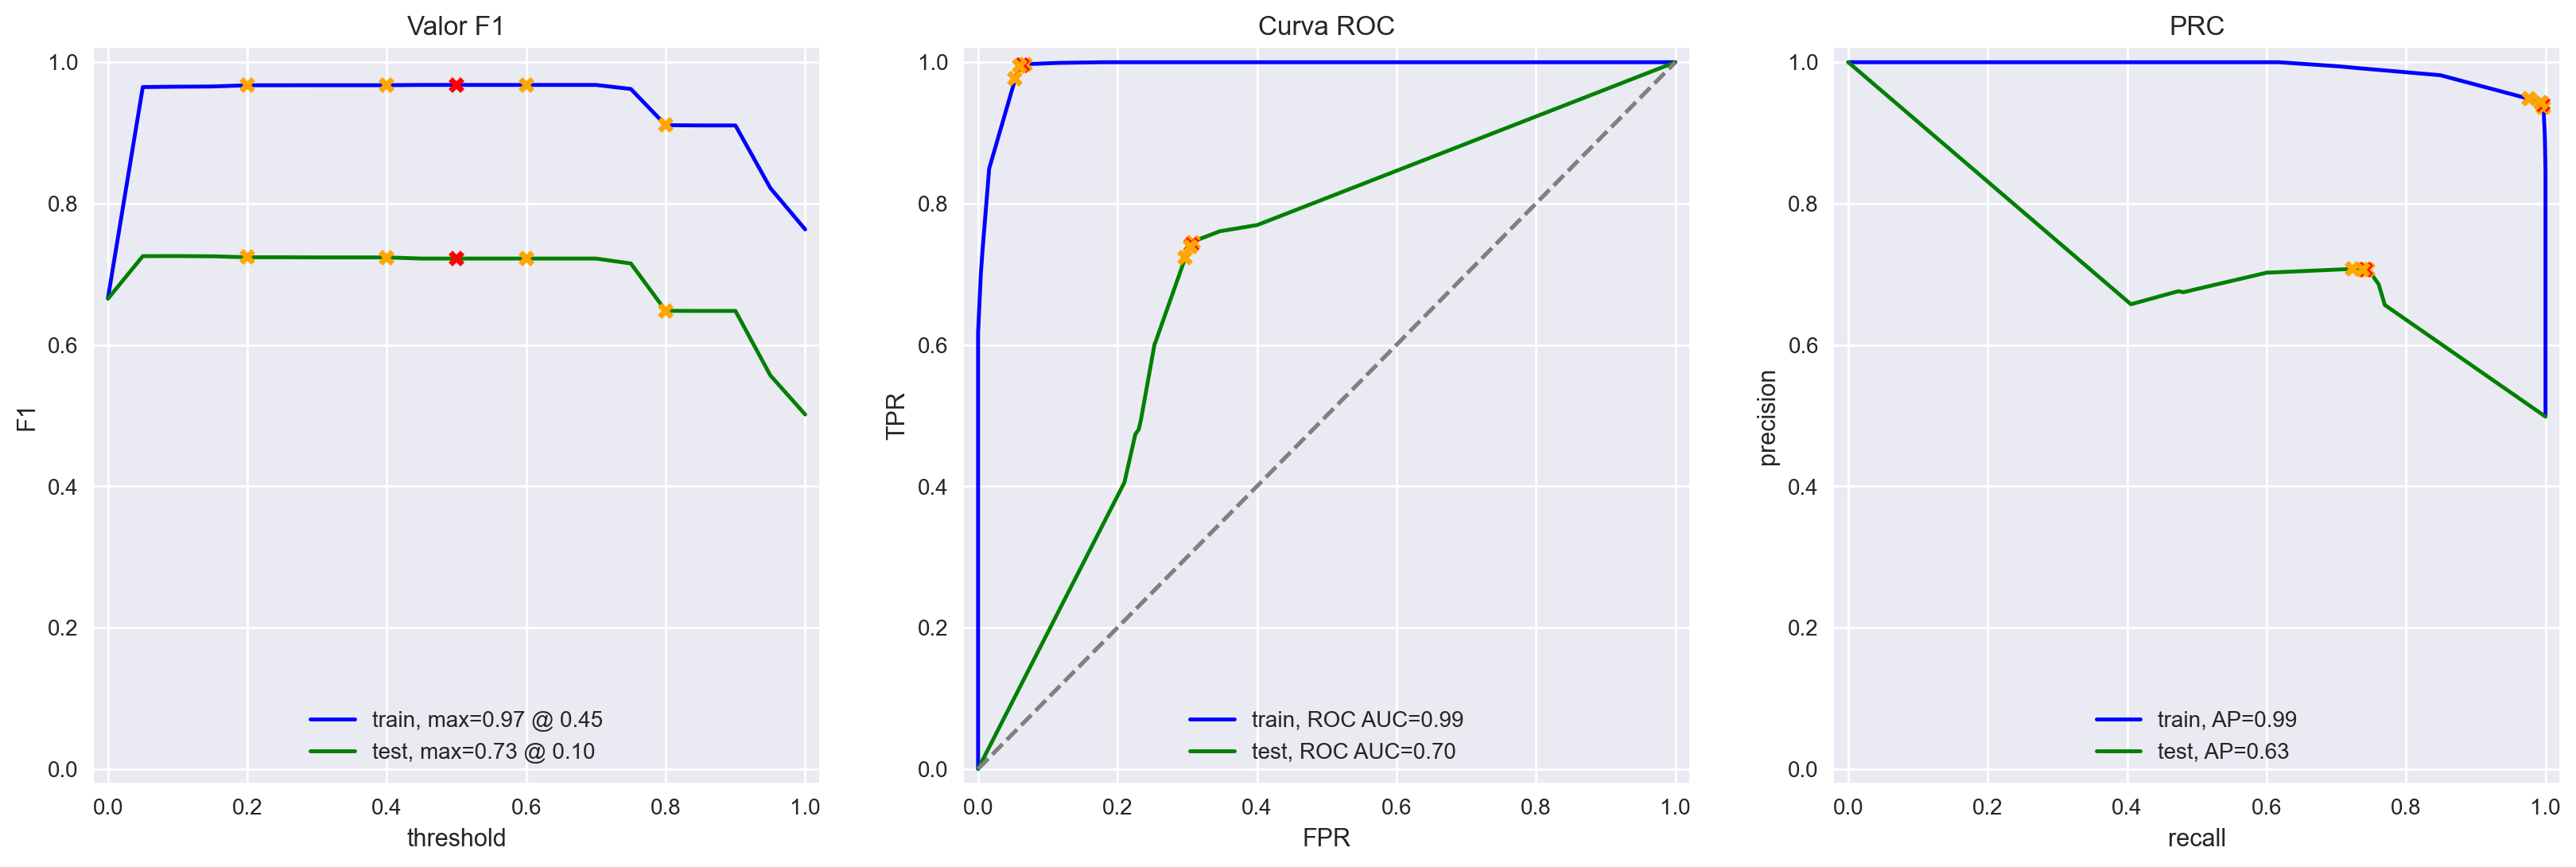

In [65]:
evaluate_model(model_2, train_features_1, train_target, test_features_1, test_target)

Aqui claramente tivemos problemas de overfit, por isso a grande diferença entre o treino e teste.

Esse overfit é inerente da estrutura da arvore, pois não temos uma profundidade com melhor resultados de teste.

### Modelo 3 - SpaCy, TF-IDF e Regressão Logistica

O spacy é um conjunto de stop words diferentes.

Com ele a vetorização do texto vai ser diferente, então os resultados podem ser melhores, piores ou o mesmo.

In [66]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

/opt/homebrew/lib/python3.11/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.7.1) was trained with spaCy v3.7.2 and may not be 100% compatible with the current version (3.8.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [67]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)
corpus=df_reviews['review_norm']
lemm=[]
for text in tqdm(corpus):
    lemm.append(text_preprocessing_3(text))
df_reviews['review_lemm']=lemm
    
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

  0%|          | 0/47329 [00:00<?, ?it/s]

In [68]:
corpus_train=df_reviews_train['review_lemm']
corpus_test=df_reviews_test['review_lemm']


vect=TfidfVectorizer(stop_words=stop_words)
train_features_2= vect.fit_transform(corpus_train)
test_features_2=vect.transform(corpus_test)

model_2=LogisticRegression()
model_2.fit(train_features_2,train_target)
print(metrics.accuracy_score(test_target, model_2.predict(test_features_2)))

0.8795308715420899


Acurácia train  : 0.9317952597075139
f1  train  : 0.9323214211250572
Acurácia test  : 0.8795308715420899
f1  test  : 0.8793154825252224
          train  test
Acurácia    NaN   NaN
F1          NaN   NaN
APS        0.98  0.95
ROC AUC    0.98  0.95


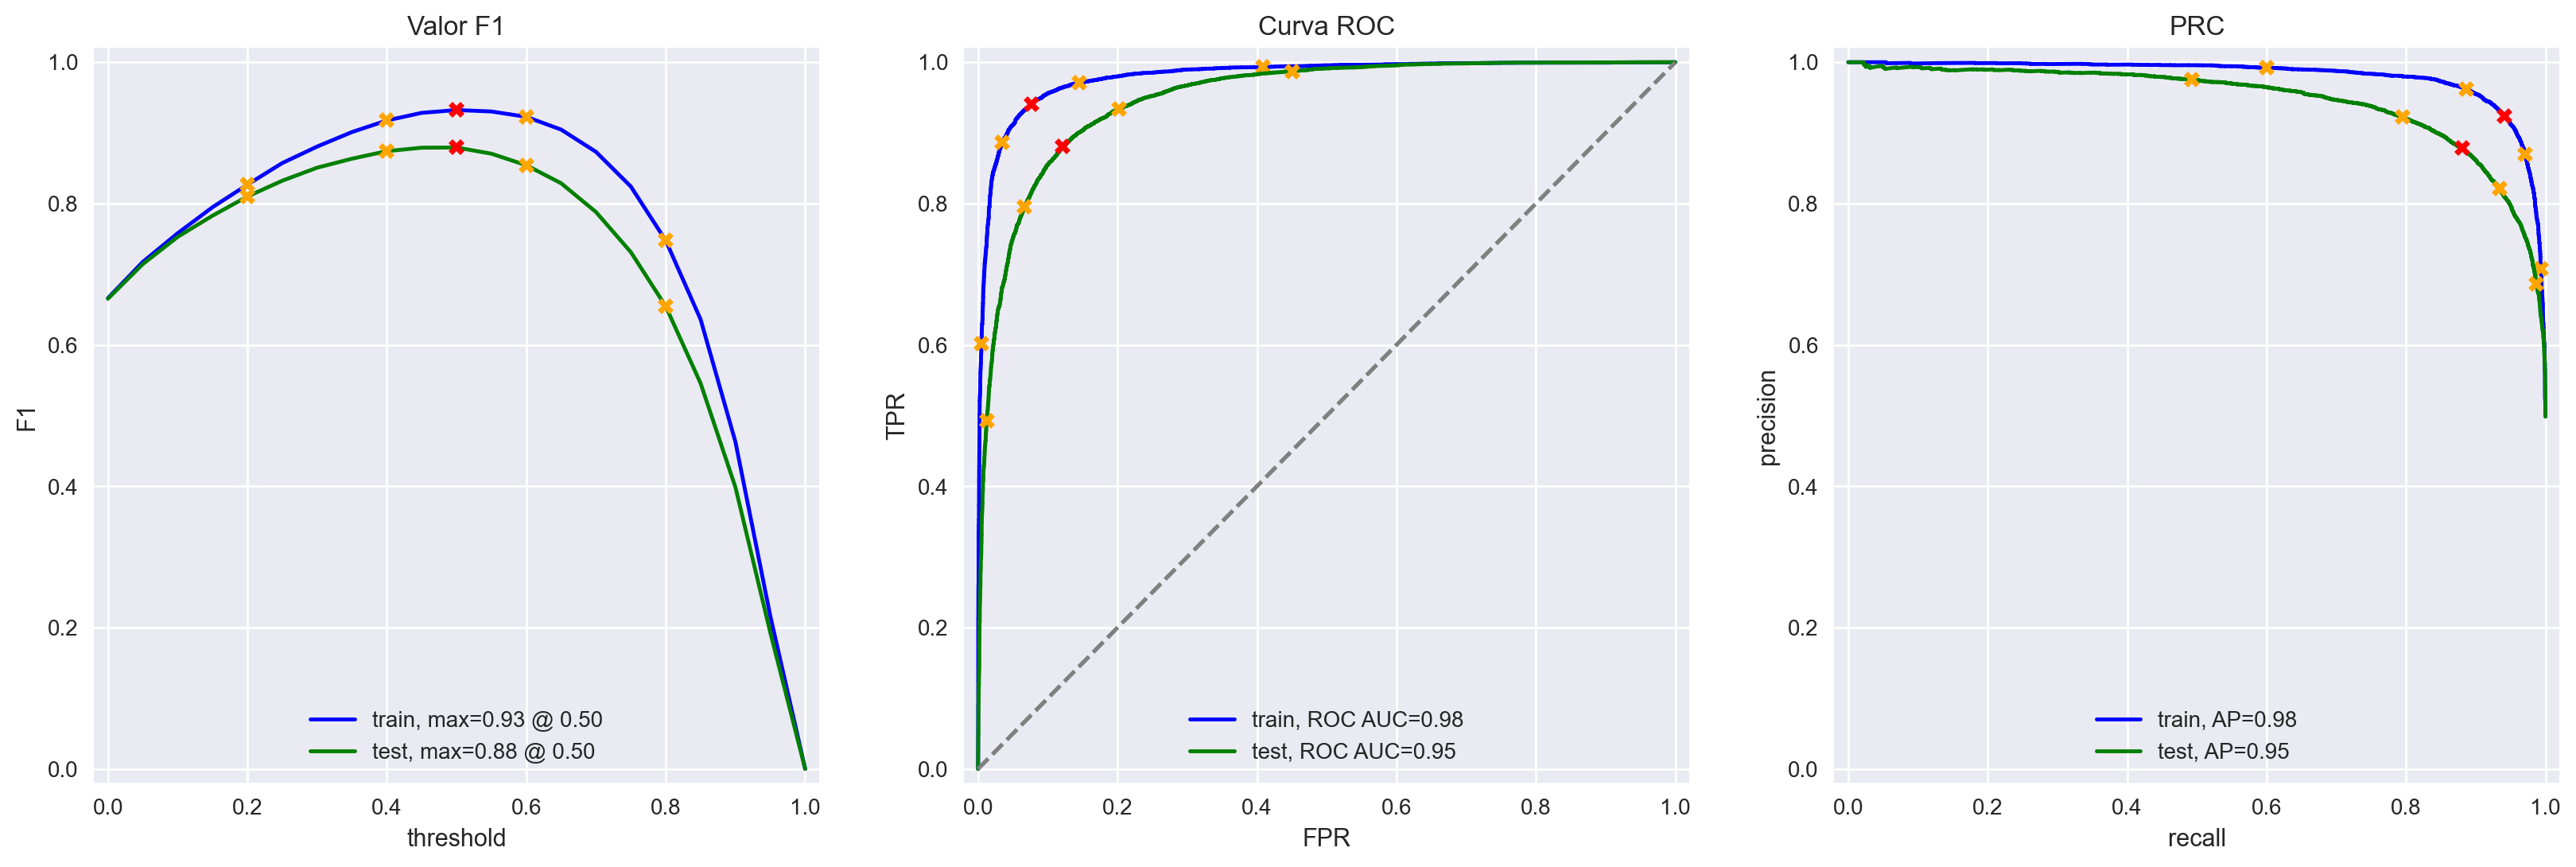

In [69]:
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

Tivemos praticamente a mesma perfomance, seja usando spacy como nosso lematizador ou NLTK, porem spacy demora bem mais tempo, por isso consideramos sua perfomance pior nesse caso

### Modelo 4 - SpaCy, TF-IDF e LGBMClassifier

O LGBMClassifier é um classificador da microsoft que tem boa precisão em comparação a outros classficadores que não usam redes neurais, alem de perfomance excelente com o multi-threading automatico e sua capacidade de converter colunas categoricas.

Ele é baseado em um modelo de floresta, onde temos multiplos modelos de arvore diferentes que votam na classe que acham correta, a classe com maior votos sendo a escolhida.

Eu recomendo sempre testar ele para tarefas de classificação.

In [70]:
from lightgbm import LGBMClassifier

In [71]:
model_3= LGBMClassifier(random_seed=12345,n_jobs=1)
model_3.fit(train_features_2,train_target)
print(metrics.accuracy_score(test_target, model_3.predict(test_features_2)))

[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.684212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 461943
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 9519
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353
0.8574342412782051


Acurácia train  : 0.9144394015800975
f1  train  : 0.9152373022481266
Acurácia test  : 0.8574342412782051
f1  test  : 0.8580615137284764
          train  test
Acurácia    NaN   NaN
F1          NaN   NaN
APS        0.97  0.93
ROC AUC    0.97  0.94


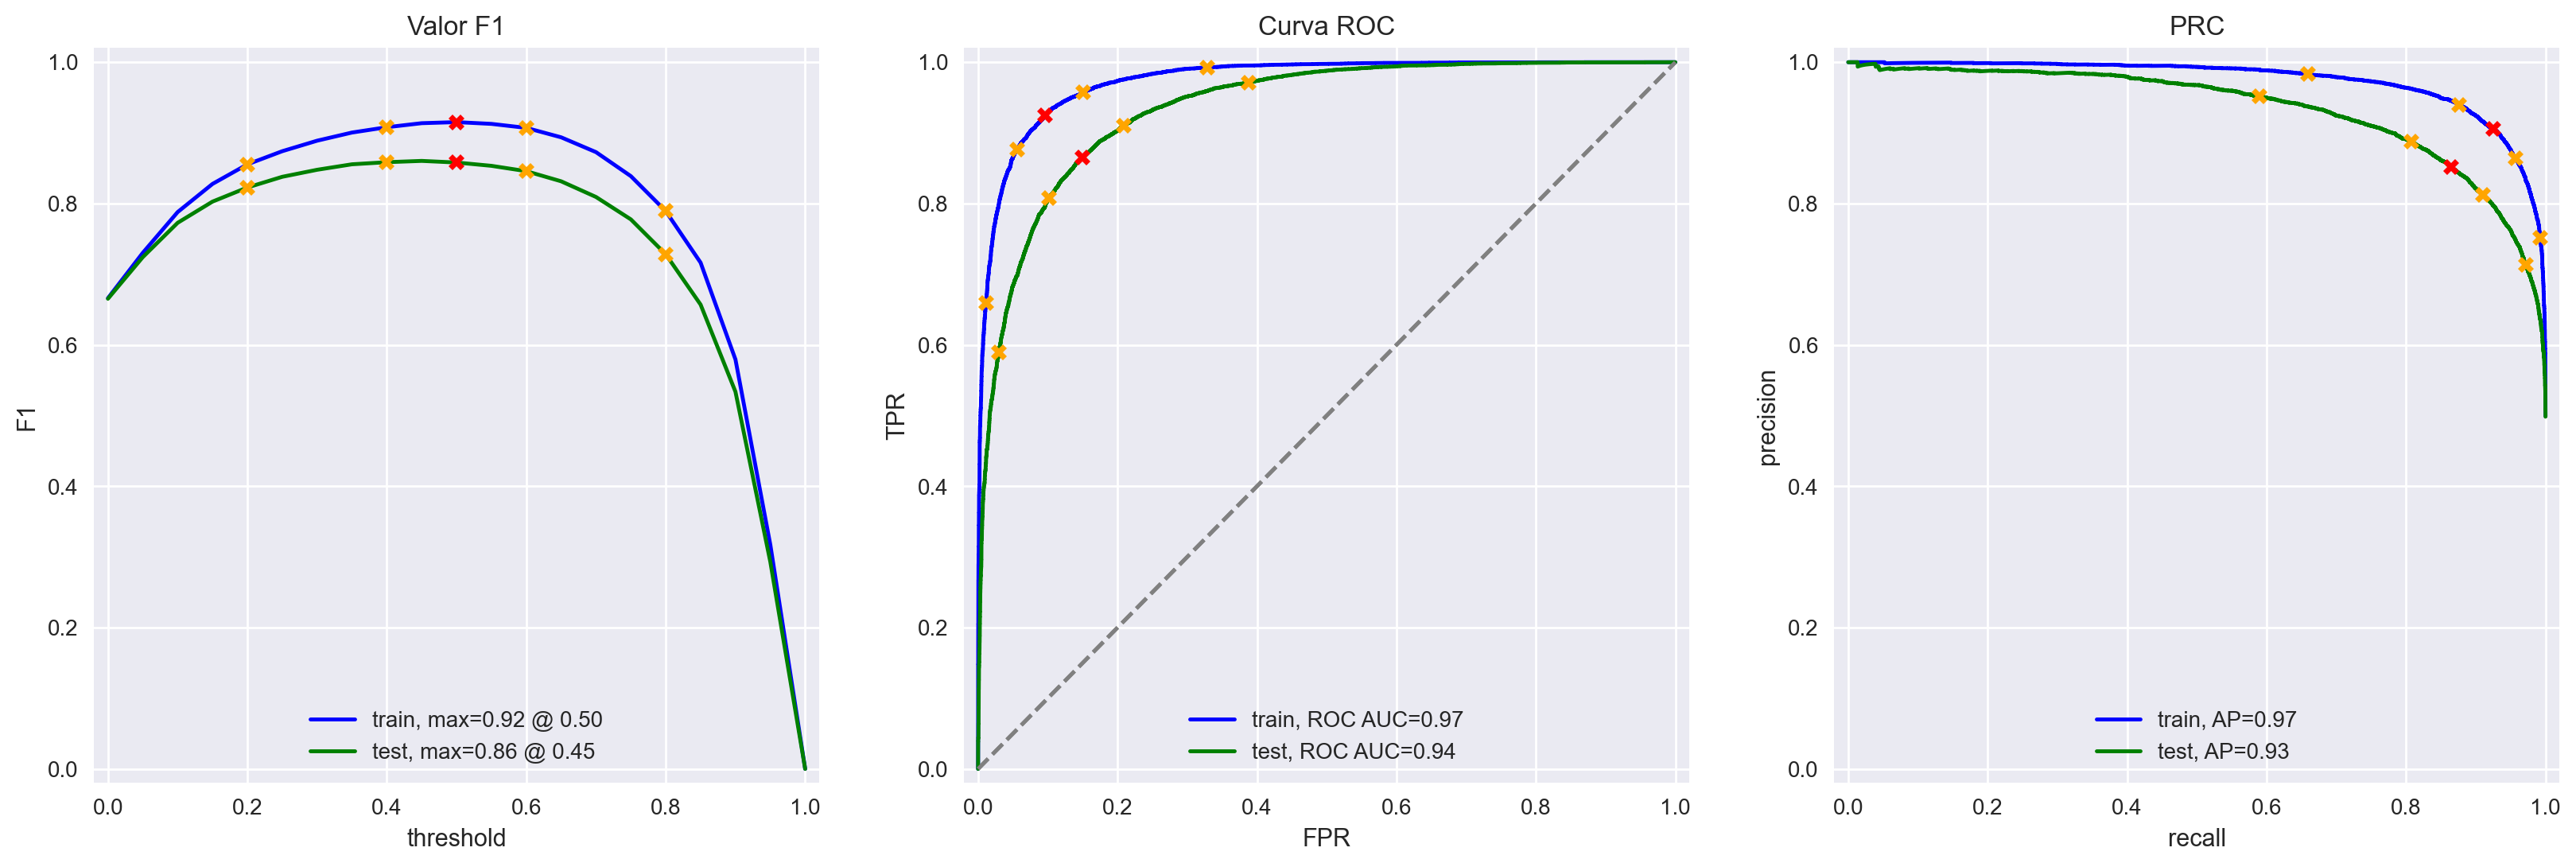

In [72]:
evaluate_model(model_3, train_features_2, train_target, test_features_2, test_target)

## Minhas Resenhas

Resenhas para testar a perfomance dos modelos e ver como eles reagem a textos em portugues, considerando que foram treinados em ingles.

In [73]:
my_reviews = pd.DataFrame([
    'Bem, eu fiquei entediado quando os macacos começaram a gritar no obelisko gigante e dormi no meio do filme.',
    'Eu fiquei realmente fascinado com o filme',    
    'Que tentativa podre de comédia. Nem uma única piada cai, todo mundo age de forma irritante e barulhenta, nem crianças não vão gostar disso!',
    'Lançar na Netflix foi uma jogada corajosa e eu realmente aprecio ser capaz de assistir episódio após episódio, deste emocionante e inteligente novo drama.',
    'The actors were old and not interested in their roles, only being there to get some money.',
    'i didnt expect the new version to be so good! The writers really cared for the original',
    'the film has its goods and bads, but it is decent. I could see myself seeing it again',
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review']

my_reviews

,review,review_norm
0,"Bem, eu fiquei entediado quando os macacos com...","Bem, eu fiquei entediado quando os macacos com..."
1,Eu fiquei realmente fascinado com o filme,Eu fiquei realmente fascinado com o filme
2,Que tentativa podre de comédia. Nem uma única ...,Que tentativa podre de comédia. Nem uma única ...
3,Lançar na Netflix foi uma jogada corajosa e eu...,Lançar na Netflix foi uma jogada corajosa e eu...
4,The actors were old and not interested in thei...,The actors were old and not interested in thei...
5,i didnt expect the new version to be so good! ...,i didnt expect the new version to be so good! ...
6,"the film has its goods and bads, but it is dec...","the film has its goods and bads, but it is dec..."


### Modelo 1

In [74]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(original_vect.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.49:  Bem, eu fiquei entediado quando os macacos começaram a gritar no obelisko gigante e dormi no meio do
0.65:  Eu fiquei realmente fascinado com o filme
0.57:  Que tentativa podre de comédia. Nem uma única piada cai, todo mundo age de forma irritante e barulhe
0.49:  Lançar na Netflix foi uma jogada corajosa e eu realmente aprecio ser capaz de assistir episódio após
0.31:  The actors were old and not interested in their roles, only being there to get some money.
0.44:  i didnt expect the new version to be so good! The writers really cared for the original
0.40:  the film has its goods and bads, but it is decent. I could see myself seeing it again


### Modelo 2

In [75]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(vect.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.48:  Bem, eu fiquei entediado quando os macacos começaram a gritar no obelisko gigante e dormi no meio do
0.59:  Eu fiquei realmente fascinado com o filme
0.57:  Que tentativa podre de comédia. Nem uma única piada cai, todo mundo age de forma irritante e barulhe
0.48:  Lançar na Netflix foi uma jogada corajosa e eu realmente aprecio ser capaz de assistir episódio após
0.35:  The actors were old and not interested in their roles, only being there to get some money.
0.58:  i didnt expect the new version to be so good! The writers really cared for the original
0.33:  the film has its goods and bads, but it is decent. I could see myself seeing it again


### Modelo 3

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(vect.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.64:  Bem, eu fiquei entediado quando os macacos começaram a gritar no obelisko gigante e dormi no meio do
0.67:  Eu fiquei realmente fascinado com o filme
0.66:  Que tentativa podre de comédia. Nem uma única piada cai, todo mundo age de forma irritante e barulhe
0.64:  Lançar na Netflix foi uma jogada corajosa e eu realmente aprecio ser capaz de assistir episódio após
0.50:  The actors were old and not interested in their roles, only being there to get some money.
0.76:  i didnt expect the new version to be so good! The writers really cared for the original
0.23:  the film has its goods and bads, but it is decent. I could see myself seeing it again


Parece que o modelo não consegue classficar avalições em portugues por não estar presente em seu vocabulario, como esperado.

Alem disso, nas avaliações em ingles, foi capaz de prever a positiva de maneira correta em ambos os casos, mas a negativa em só um deles, com o LGBMClassifier o caracterizando como 0.50, exatamente no ponto de virada entre positivo e negativo.

Ademais, a avaliação que diz que o filme é mais ou menos em ingles é reconhecida de maneira excessivamente negativa por ambos os modelos, talvez mostrando uma falta de compreensão da organização de frases e nuancia da linguaguem em relação a avaliações que não são extremas, seria interessante analizar o quão polarizadas ou radicais são as avaliações no banco de dados e ver se é um fator que influencia a falta de nuancia do modelo.

Parece que o modelo LightLGBM tem a tendencia a apresentar resultados mais positivos comparado a regressão logistica

## Conclusões

O motivo da diferença dos resultados nas resenhas para o banco de dados provavelmente vem do fato de estarem em linguagems diferentes, assim o "dicionario" em que o modelo foi treinado não inclui as palavras em portugues

Alguns filmes tem muito mais resenhas que outros, provavelmente por serem mais populares, mas alem de desequilibrar a classe, isso pode levar a uma limitação do vocabulario do modelo

E alguns anos tambem tem muitos mais filmes que outros, com uma faixa de 1999 a 2009, 10 anos, como pico

As classes estão desequilibradas, com a quantidade de 1 ou positivos sendo o dobro de negativos ou 0, talvez seja interessante aplicar tecnicas para equilibrar mais as classes como upsampling ou dar pesos em modelos como no BERT, caso ele fosse usado.

O melhor modelo foi a regressão logistica sem o processamento de texto do spacy, tendo a melhor precisão de todos os modelos e a melhor velocidade, com 3 minutos para processar o texto e baixo tempo de execução, comparado aos 20 minutos de processamento do spacy, e menor tempo de execução em relação ao LGBM.

O pior modelo foi o classificador LGBM,mesmo sendo uma otima biblioteca para outros tipos de classificação, que envolvem dados categoricos por exemplo.